<a href="https://colab.research.google.com/github/Enterprise-D/sc_multimodal/blob/main/multimodal_tsvd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Colab Administrative

Mount Google Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Compression

Install and load h5df modules:

In [ ]:
import h5py

!pip install hdf5plugin
import hdf5plugin

handle inputs:

In [ ]:
path_train_multi_inputs = '/content/drive/MyDrive/multimodal/train_multi_inputs.h5'
file_train_multi_inputs = h5py.File(path_train_multi_inputs, "r")

path_test_multi_inputs = '/content/drive/MyDrive/multimodal/test_multi_inputs.h5'
file_test_multi_inputs = h5py.File(path_test_multi_inputs, "r")

file_train_multi_inputs.keys(), file_test_multi_inputs.keys()

In [ ]:
group_train_multi_inputs = file_train_multi_inputs['train_multi_inputs']

group_test_multi_inputs = file_test_multi_inputs['test_multi_inputs']

group_train_multi_inputs.keys(), group_test_multi_inputs.keys()

In [ ]:
group_train_multi_inputs['block0_values'].shape, \
group_test_multi_inputs['block0_values'].shape
# axis0 & block0_items: features (genomic coordinates, GRCh38)
# axis1: cell_ids
# block0_values: entries

In [ ]:
group_train_multi_inputs['block0_values'][1:10,1:6]

handle targets:

In [ ]:
path_train_multi_targets = '/content/drive/MyDrive/multimodal/train_multi_targets.h5'
file_train_multi_targets = h5py.File(path_train_multi_targets, "r")

file_train_multi_targets.keys()

In [ ]:
group_train_multi_targets = file_train_multi_targets['train_multi_targets']
group_train_multi_targets.keys()

In [ ]:
group_train_multi_targets['block0_values'].shape
# axis0 & block0_items: features (expression reads, GRCh38)
# axis1: cell_ids
# block0_values: entries

In [ ]:
group_train_multi_targets['block0_values'][1:10,1:6]

In [ ]:
import numpy as np
import pandas as pd
import os
import scipy.sparse as sps
from tqdm import tqdm as tqdm
import gc

Datasets are too sparse:

In [ ]:
%load_ext Cython

In [ ]:
%%cython

import cython
cimport cython
cimport numpy as np
import numpy as np
from tqdm import tqdm, trange

ctypedef np.int64_t INT64_t

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef np.ndarray[INT64_t, ndim=1] create_indptr(INT64_t[:] row_indices, int start_pos, int nrows):
    cdef int shape = row_indices.shape[0]
    res = np.zeros(nrows, dtype=np.int64)
    cdef INT64_t[:] res_view = res
    
    cdef int i
    cdef int curr_row = 0
    cdef int prev = row_indices[0]
    
    for i in range(shape):
        if row_indices[i] != prev:
            curr_row += 1
            res_view[curr_row] = i
            prev = row_indices[i]
    # res_view[curr_row + 1] = shape
    return res + start_pos

In [ ]:
def create_csr_arrays(h5_file_path):
    def check_size(xs, ys, datas):
        return (xs.nbytes + ys.nbytes + datas.nbytes) * 1e-9

    print(f"\n\nProcessing File {h5_file_path}")
    pbar = tqdm()

    # Initialize Variables
    chunksize = 1000 # Keep it low
    loaded_rows = chunksize
    start = 0
    start_pos = 0
    file_pointer = 0

    # Initialize CSR arrays
    indptr = np.array([], dtype=np.int64)
    indices = np.array([], dtype=np.int32)
    data_s = np.array([], dtype=np.float32)
    
    prefix_filename = h5_file_path.split('/')[-1].replace('.h5', '')

    while chunksize == loaded_rows:

        # Check current size: if the total sum of sizes are > 7GB, then save three arrays and re-initialize them
        size_gb = check_size(indptr, indices, data_s)
        if size_gb > 7.0:
            pbar.set_description(f"Total size is {size_gb}. Saving ..")
            np.save(f"{prefix_filename}_indptr_{file_pointer}.npy", indptr)
            np.save(f"{prefix_filename}_indices_{file_pointer}.npy", indices)
            np.save(f"{prefix_filename}_data_{file_pointer}.npy", data_s)
            # Re-initialize
            indptr = np.array([], dtype=np.int64)
            indices = np.array([], dtype=np.int32)
            data_s = np.array([], dtype=np.float32)
            # Increment pointer
            file_pointer += 1

        pbar.set_description("Reading .h5 chunk")
        df = pd.read_hdf(h5_file_path, start=start, stop=start+chunksize)
        pbar.set_description("Extracting non-zero values")
        x_coords, y_coords = df.values.nonzero()
        tmp_data = df.values[df.values != 0.0]

        loaded_rows = df.shape[0]

        # Convert types
        y_coords = y_coords.astype(np.int32, copy=False)
        tmp_data = tmp_data.astype(np.float32, copy=False)

        # Compress x_coords
        pbar.set_description("Compressing rows values")
        x_coords = create_indptr(x_coords, start_pos=start_pos, nrows=loaded_rows)

        gc.collect()

        # Update variables
        pbar.set_description("Update variables")
        start_pos += y_coords.shape[0]
        start += chunksize
        # Append data at the end of each array
        indptr = np.hstack((indptr, x_coords))
        indices = np.hstack((indices, y_coords))
        data_s = np.hstack((data_s, tmp_data))

        pbar.update(loaded_rows)

    print('Done. Save last files')
    np.save(f"{prefix_filename}_indptr_{file_pointer}.npy", indptr)
    np.save(f"{prefix_filename}_indices_{file_pointer}.npy", indices)
    np.save(f"{prefix_filename}_data_{file_pointer}.npy", data_s)
    
    del indptr, indices, data_s

In [ ]:
create_csr_arrays(path_train_multi_inputs)

In [ ]:
indptr = np.load('train_multi_inputs_indptr_0.npy')
indices = np.load('train_multi_inputs_indices_0.npy')
data = np.load('train_multi_inputs_data_0.npy')
indptr = np.append(indptr, indptr[-1] + indices[indptr[-1]:].shape)
N_ROWS = group_train_multi_inputs['block0_values'].shape[0]
N_COLS = group_train_multi_inputs['block0_values'].shape[1]
csr_matrix = sps.csr_matrix((data, indices, indptr), shape=(N_ROWS, N_COLS))
sps.save_npz('train_multi_inputs_sparse.npz', csr_matrix)
del csr_matrix, indices, indptr, data

In [ ]:
create_csr_arrays(path_train_multi_targets)

In [ ]:
indptr = np.load('train_multi_targets_indptr_0.npy')
indices = np.load('train_multi_targets_indices_0.npy')
data = np.load('train_multi_targets_data_0.npy')
indptr = np.append(indptr, indptr[-1] + indices[indptr[-1]:].shape)
N_ROWS = group_train_multi_targets['block0_values'].shape[0]
N_COLS = group_train_multi_targets['block0_values'].shape[1]
csr_matrix = sps.csr_matrix((data, indices, indptr), shape=(N_ROWS, N_COLS))
sps.save_npz('train_multi_targets_sparse.npz', csr_matrix)
del csr_matrix, indices, indptr, data

In [ ]:
create_csr_arrays(path_test_multi_inputs)

In [ ]:
indptr = np.load('test_multi_inputs_indptr_0.npy')
indices = np.load('test_multi_inputs_indices_0.npy')
data = np.load('test_multi_inputs_data_0.npy')
indptr = np.append(indptr, indptr[-1] + indices[indptr[-1]:].shape)
N_ROWS = group_test_multi_inputs['block0_values'].shape[0]
N_COLS = group_test_multi_inputs['block0_values'].shape[1]
csr_matrix = sps.csr_matrix((data, indices, indptr), shape=(N_ROWS, N_COLS))
sps.save_npz('test_multi_inputs_sparse.npz', csr_matrix)
del csr_matrix, indices, indptr, data

In [ ]:
!mv *.npy /content/drive/MyDrive/multimodal_sparse
!mv *.npz /content/drive/MyDrive/multimodal_sparse

## Splitting, Denoising and Normalization

In [1]:
import random
import joblib
import numpy as np
import pandas as pd
from sklearn import decomposition, model_selection

import os
import gc
import scipy.sparse as sps
from tqdm import tqdm as tqdm

Fix random seeds:

In [2]:
random_seed = 3407
random.seed(random_seed)
np.random.seed(random_seed)

### Split datasets into training and validation parts:

Copy data to local disk and load into python:

In [ ]:
!cp /content/drive/MyDrive/multimodal_sparse/*.npz /content/

In [ ]:
input_csr = sps.load_npz('/content/train_multi_inputs_sparse.npz')

In [ ]:
target_csr = sps.load_npz('/content/train_multi_targets_sparse.npz')

In [ ]:
input_csr.shape, target_csr.shape

In [ ]:
! rm *.npz

Split datasets in advance to prevent model from seeing validation data:

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(input_csr,
                                                                    target_csr, 
                                                                    test_size=0.2, 
                                                                    random_state = random_seed)
del input_csr, target_csr

sps.save_npz('X_train.npz', X_train)
del X_train

sps.save_npz('X_test.npz', X_test)
del X_test

sps.save_npz('y_train.npz', y_train)
del y_train

sps.save_npz('y_test.npz', y_test)
del y_test

In [ ]:
!cp *.npz /content/drive/MyDrive/multimodal_split

In [ ]:
!cp /content/drive/MyDrive/multimodal_split/*.npz /content/

In [ ]:
# be careful with memory quota
train_input = sps.load_npz('X_train.npz')

nmf_input = joblib.load("/content/drive/MyDrive/multimodal_nmf/nmf_input.pkl")

#nmf_input = decomposition.NMF(n_components=128, init='nndsvd',max_iter=150)
#W_train_input = nmf_input.fit_transform(train_input)
W_train_input = nmf_input.transform(train_input)
H_train_input = nmf_input.components_

np.save("W_train_input.npy", W_train_input)
np.save("H_train_input.npy", H_train_input)

del train_input

In [ ]:
valid_input = sps.load_npz('X_test.npz')

W_valid_input = nmf_input.transform(valid_input)
H_valid_input = nmf_input.components_

np.save("W_valid_input.npy", W_valid_input)
np.save("H_valid_input.npy", H_valid_input)

joblib.dump(nmf_input, '/content/drive/MyDrive/multimodal_nmf/nmf_input.pkl')

del valid_input, nmf_input

#H_train_input == H_valid_input?

In [ ]:
train_target = sps.load_npz('y_train.npz')

nmf_target = decomposition.NMF(n_components=128, init='nndsvd', max_iter=150)
W_train_target = nmf_target.fit_transform(train_target)
H_train_target = nmf_target.components_

np.save("W_train_target.npy", W_train_target)
np.save("H_train_target.npy", H_train_target)

del train_target

In [ ]:
valid_target = sps.load_npz('y_test.npz')

W_valid_target = nmf_target.transform(valid_target)
H_valid_target = nmf_target.components_

np.save("W_valid_target.npy", W_valid_target)
np.save("H_valid_target.npy", H_valid_target)

joblib.dump(nmf_target, '/content/drive/MyDrive/multimodal_nmf/nmf_target.pkl')

del valid_target, nmf_target

In [ ]:
!mv *.npy /content/drive/MyDrive/multimodal_nmf

### Truncated SVD

In [3]:
!cp /content/drive/MyDrive/multimodal_split/*.npz /content/

For regular data:

In [ ]:
train_input= sps.load_npz('X_train.npz')

# be careful with memory quota
tsvd_input = decomposition.TruncatedSVD(n_components=128,algorithm='arpack',random_state=random_seed)
U_train_input = tsvd_input.fit_transform(train_input)
s_train_input = tsvd_input.singular_values_
Va_train_input = tsvd_input.components_

np.save("U_train_input.npy", U_train_input)
np.save("s_train_input.npy", s_train_input)
np.save("Va_train_input.npy", Va_train_input)

del train_input

!mv *.npy /content/drive/MyDrive/multimodal_tsvd_arpack

In [ ]:
valid_input = sps.load_npz('X_test.npz')

U_valid_input = tsvd_input.transform(valid_input)
s_valid_input = tsvd_input.singular_values_
Va_valid_input = tsvd_input.components_

np.save("U_valid_input.npy", U_valid_input)
np.save("s_valid_input.npy", s_valid_input)
np.save("Va_valid_input.npy", Va_valid_input)

joblib.dump(tsvd_input, '/content/drive/MyDrive/multimodal_tsvd/tsvd_input.pkl')

del valid_input, tsvd_input

!mv *.npy /content/drive/MyDrive/multimodal_tsvd_arpack

In [ ]:
# be careful with memory quota
train_target = sps.load_npz('y_train.npz')

tsvd_target = decomposition.TruncatedSVD(n_components=128,algorithm='arpack',random_state=random_seed)
U_train_target = tsvd_target.fit_transform(train_target)
s_train_target = tsvd_target.singular_values_
Va_train_target = tsvd_target.components_

np.save("U_train_target.npy", U_train_target)
np.save("s_train_target.npy", s_train_target)
np.save("Va_train_target.npy", Va_train_target)

del train_target

!mv *.npy /content/drive/MyDrive/multimodal_tsvd_arpack

In [ ]:
valid_target = sps.load_npz('y_test.npz')

U_valid_target = tsvd_target.transform(valid_target)
s_valid_target = tsvd_target.singular_values_
Va_valid_target = tsvd_target.components_

np.save("U_valid_target.npy", U_valid_target)
np.save("s_valid_target.npy", s_valid_target)
np.save("Va_valid_target.npy", Va_valid_target)

joblib.dump(tsvd_target, '/content/drive/MyDrive/multimodal_tsvd/tsvd_target.pkl')

del valid_target, tsvd_target

!mv *.npy /content/drive/MyDrive/multimodal_tsvd_arpack

For binarized data:

In [ ]:
train_input_binary = sps.load_npz('X_train.npz').astype('uint8')
train_input_binary[train_input_binary.nonzero()]=1

tsvd_input_binary = decomposition.TruncatedSVD(n_components=128)
U_train_input_binary = tsvd_input_binary.fit_transform(train_input_binary)
s_train_input_binary = tsvd_input_binary.singular_values_
Va_train_input_binary = tsvd_input_binary.components_

np.save("U_train_input_binary.npy", U_train_input_binary)
np.save("s_train_input_binary.npy", s_train_input_binary)
np.save("Va_train_input_binary.npy", Va_train_input_binary)

del train_input_binary

!mv *.npy /content/drive/MyDrive/multimodal_tsvd

In [ ]:
valid_input_binary = sps.load_npz('X_test.npz').astype('uint8')
valid_input_binary[valid_input_binary.nonzero()]=1

U_valid_input_binary = tsvd_input_binary.transform(valid_input_binary)
s_valid_input_binary = tsvd_input_binary.singular_values_
Va_valid_input_binary = tsvd_input_binary.components_

np.save("U_valid_input_binary.npy", U_valid_input_binary)
np.save("s_valid_input_binary.npy", s_valid_input_binary)
np.save("Va_valid_input_binary.npy", Va_valid_input_binary)

joblib.dump(tsvd_input_binary, '/content/drive/MyDrive/multimodal_tsvd/tsvd_input_binary.pkl')

del valid_input_binary, tsvd_input_binary

!mv *.npy /content/drive/MyDrive/multimodal_tsvd

## PyTorch Workflow (tSVD)

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.utils.data.sampler import SubsetRandomSampler

import random
import numpy as np
import pandas as pd
import scipy.sparse as sps
from scipy import stats

import matplotlib.pyplot as plt

Fix random seeds:

In [2]:
random_seed = 3407
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

Prepare files:

In [3]:
!cp /content/drive/MyDrive/multimodal_tsvd/*.npy /content/

In [3]:
U_train_input = np.load("U_train_input.npy")
U_train_target = np.load("U_train_target.npy")

U_valid_input = np.load("U_valid_input.npy")
U_valid_target = np.load("U_valid_target.npy")

In [23]:
!cp /content/drive/MyDrive/multimodal_split/y_train.npz /content/
!cp /content/drive/MyDrive/multimodal_split/y_test.npz /content/

In [24]:
train_target = sps.load_npz('y_train.npz')
valid_target = sps.load_npz('y_test.npz')

#### Normalize targets (for MSE calculation):

In [9]:
U_train_input_std = U_train_input.std(axis=1).reshape(-1, 1)
#U_train_input_avg = U_train_input.mean(axis=1).reshape(-1, 1)
U_train_input_norm = U_train_input / U_train_input_std

U_train_target_std = U_train_target.std(axis=1).reshape(-1, 1)
#U_train_target_avg = U_train_target.mean(axis=1).reshape(-1, 1)
U_train_target_norm = U_train_target / U_train_target_std

In [10]:
U_valid_input_std = U_valid_input.std(axis=1).reshape(-1, 1)
#U_valid_input_avg = U_valid_input.mean(axis=1).reshape(-1, 1)
U_valid_input_norm = U_valid_input / U_valid_input_std

U_valid_target_std = U_valid_target.std(axis=1).reshape(-1, 1)
#U_valid_target_avg = U_valid_target.mean(axis=1).reshape(-1, 1)
U_valid_target_norm = U_valid_target / U_valid_target_std

#### Construct dataset and dataloader:

In [38]:
class TrainDataset(Data.Dataset):
    def __init__(self):
      self.inputs_data = torch.from_numpy(U_train_input_norm.astype('float32')).cuda()
      self.targets_data = torch.from_numpy(U_train_target_norm.astype('float32')).cuda()
      # send to GPU as a whole due to small size.

    def __len__(self):
      return self.inputs_data.shape[0]

    def __getitem__(self, idx):
      inputs_sliced = self.inputs_data[idx, ...]
      targets_sliced = self.targets_data[idx, ...]

      return inputs_sliced, targets_sliced

class ValidDataset(Data.Dataset):
    def __init__(self):
      self.inputs_data = torch.from_numpy(U_valid_input_norm.astype('float32')).cuda()
      self.targets_data = torch.from_numpy(U_valid_target_norm.astype('float32')).cuda()
      self.true_data_cpu = torch.from_numpy(valid_target.todense())
      # large true data, send accordingly

    def __len__(self):
      return self.inputs_data.shape[0]

    def __getitem__(self, idx):
      inputs_sliced = self.inputs_data[idx, ...]
      targets_sliced = self.targets_data[idx, ...]
      true_sliced_cpu = self.true_data_cpu[idx, ...]

      return inputs_sliced, targets_sliced, true_sliced_cpu

In [39]:
batch_size = 256

train_dataloader = torch.utils.data.DataLoader(TrainDataset(),
                                               batch_size=batch_size,
                                               shuffle = True)
valid_dataloader = torch.utils.data.DataLoader(ValidDataset(), 
                                               batch_size=batch_size,
                                               shuffle = True)

len(train_dataloader), len(valid_dataloader)

(332, 83)

#### Construct and train a MLP model:

In [40]:
class DenseModel(nn.Module):
    def __init__(self,
                 input_size=U_train_input.shape[1],
                 output_size=U_train_target.shape[1],
                 hidden_size=256):

        super(DenseModel, self).__init__()
        self.dense1 = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU())
        
        self.dense2 = nn.Sequential(
            nn.Dropout(0.3),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU())
        
        self.dense3 = nn.Sequential(
            nn.Dropout(0.3),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU())
        
        self.dense4 = nn.Sequential(
            nn.Dropout(0.3),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU())
        
        self.dense5 = nn.Sequential(
            nn.Dropout(0.3),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU())
                
        self.dense6 = nn.Sequential(
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, output_size))

    def forward(self, input):
        output = self.dense1(input)
        output = self.dense2(output)
        output = self.dense3(output)
        output = self.dense4(output)
        output = self.dense5(output)
        output = self.dense6(output)
        return output

In [41]:
dense_model = DenseModel().cuda()

In [42]:
criterion = nn.MSELoss()

num_epochs = 100
learning_rate = 0.003
optimizer = torch.optim.Adam(params=dense_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [43]:
metric_train = np.zeros(shape=num_epochs)
metric_valid = np.zeros(shape=num_epochs)

for epoch in range(num_epochs):
    loss_train = np.zeros(shape=len(train_dataloader))
    weights_train = np.zeros(shape=len(train_dataloader))
    
    for i, (inputs, targets) in enumerate(train_dataloader):
        weights_train[i] = targets.shape[0]

        dense_model.train()

        outputs = dense_model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        dense_model.eval()
        with torch.no_grad():
          outputs = dense_model(inputs)
          loss_train[i] = criterion(outputs, targets)

    loss_valid = np.zeros(shape=len(valid_dataloader))
    weights_valid = np.zeros(shape=len(valid_dataloader))

    with torch.no_grad():
        for i, (inputs, targets, _) in enumerate(valid_dataloader):
          weights_valid[i] = targets.shape[0]

          outputs = dense_model(inputs)
          loss_valid[i] = criterion(outputs, targets)

    metric_train[epoch] = np.average(loss_train, weights=weights_train)
    metric_valid[epoch] = np.average(loss_valid, weights=weights_valid)

    scheduler.step(metric_valid[epoch])

    print('epoch', epoch+1,
          '| train_loss:',round(metric_train[epoch],4),
          '| valid_loss:',round(metric_valid[epoch],4))

IndexError: ignored

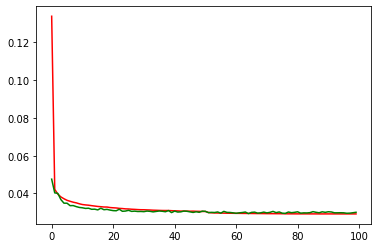

In [ ]:
plt.plot(metric_train, color='r')
plt.plot(metric_valid, color='g')
plt.show()

#### Evaluation by correlation

In [12]:
#s_train_input = torch.from_numpy(np.diag(np.load("s_train_input.npy")).astype('float32')).cuda()
#s_train_target = torch.from_numpy(np.diag(np.load("s_train_target.npy")).astype('float32')).cuda()

#s_valid_input = torch.from_numpy(np.diag(np.load("s_valid_input.npy")).astype('float32')).cuda()
s_valid_target = torch.from_numpy(np.diag(np.load("s_valid_target.npy")).astype('float32')).cuda()

#Va_train_input = torch.from_numpy(np.load("Va_train_input.npy").astype('float32')).cuda()
#Va_train_target = torch.from_numpy(np.load("Va_train_target.npy").astype('float32')).cuda()

#Va_valid_input = torch.from_numpy(np.load("Va_valid_input.npy").astype('float32')).cuda()
Va_valid_target = torch.from_numpy(np.load("Va_valid_target.npy").astype('float32')).cuda()

In [6]:
def pcorr_vec(X,Y):
  Xnorm = X-X.mean(axis=1).reshape(-1, 1)
  Ynorm = Y-Y.mean(axis=1).reshape(-1, 1)
  cov = torch.diagonal(torch.matmul(Xnorm,torch.transpose(Ynorm,1,0)))
  Xsigma2 = torch.diagonal(torch.matmul(Xnorm,torch.transpose(Xnorm,1,0)))
  Ysigma2 = torch.diagonal(torch.matmul(Ynorm,torch.transpose(Ynorm,1,0)))
  sigma = torch.sqrt(torch.mul(Xsigma2,Ysigma2))
  return torch.mean(cov/sigma)

In [45]:
dense_model.eval()

pcorr_avg_decomp = np.zeros(shape=len(valid_dataloader))
pcorr_avg_recomp = np.zeros(shape=len(valid_dataloader))
pcorr_avg_true = np.zeros(shape=len(valid_dataloader))
weights = np.zeros(shape=len(valid_dataloader))

with torch.no_grad():
    for i, (inputs, targets, true) in enumerate(valid_dataloader):

      outputs = dense_model(inputs)

      A_targets = torch.matmul(torch.matmul(targets,s_valid_target),Va_valid_target)
      A_outputs = torch.matmul(torch.matmul(targets,s_valid_target),Va_valid_target)
      
      weights[i] = A_outputs.shape[0]
      pcorr_avg_decomp[i] = pcorr_vec(targets,outputs)
      pcorr_avg_recomp[i] = pcorr_vec(A_targets,A_outputs)
      pcorr_avg_true[i] = pcorr_vec(true.cuda(),A_outputs)

score_decomp = round(np.average(pcorr_avg_decomp,weights = weights),6)
score_recomp = round(np.average(pcorr_avg_recomp,weights = weights),6)
score_true = round(np.average(pcorr_avg_true,weights = weights),6)

score_decomp, score_recomp, score_true

NameError: ignored

In [25]:
Mtrain = torch.from_numpy(train_target[0:2000].todense()).cuda()
Mvalid = torch.from_numpy(valid_target[0:2000].todense()).cuda()
Utrain = torch.from_numpy(U_train_target_norm[0:2000]).cuda()
Uvalid = torch.from_numpy(U_valid_target_norm[0:2000]).cuda()

In [29]:
Atrain = torch.matmul(torch.matmul(Utrain,s_valid_target),Va_valid_target)
Avalid = torch.matmul(torch.matmul(Uvalid,s_valid_target),Va_valid_target)

In [30]:
pcorr_vec(Mtrain,Atrain), pcorr_vec(Mvalid,Avalid)

(tensor(0.6826, device='cuda:0'), tensor(0.6819, device='cuda:0'))